In [1]:
import s3fs
import warnings
import time
import re
import pandas as pd
import numpy as np
import os
import itertools
import multiprocessing
import pickle
import tensorflow as tf
import matplotlib
import matplotlib.pylab as plt
from tensorflow import keras
from functools import partial
from itertools import repeat
from datetime import datetime
from sagemaker import get_execution_role
from dataHandling import dataHandling
from batchTools import batchTools
from gruDataReshaper import gruDataReshaper

In [2]:
calendarDF = pd.DataFrame({'date_last':pd.date_range('2019-10-31', periods=15, freq='-65B').strftime('%Y-%m-%d')})

In [3]:
def readOldResult(nAhead, sMarket):
    tmpDir = os.path.join(os.path.dirname(os.getcwd()), 'out/performance/{}/{}'.format('2020-01-08', sMarket))
    tmpDF = pd.read_csv(os.path.join(tmpDir,'{:03}_result_accuracy.csv'.format(nAhead)))
    return tmpDF

def readNewResult(nStage, performanceDir):
    tmpDF = pd.read_csv(os.path.join(performanceDir,'stage_{:03}.csv'.format(nStage)))
    tmpDF = tmpDF.loc[tmpDF['class']=='test']
    return tmpDF
def comMeasure(DF):
    DF['rate_real'] = (DF['y_frct']-DF['y_base'])/DF['y_base']
    DF['rate_pred'] = (DF['reconverted_prediction']-DF['y_base'])/DF['y_base']
    corr = DF[['rate_real','rate_pred']].corr().iloc[0,1]
    rmse = np.sqrt(((DF['rate_real']-DF['rate_pred'])**2).mean())
    direction = np.where(np.sign(DF['rate_real'])==np.sign(DF['rate_pred']), 1, 0).mean()
    interval = np.where((DF['reconverted_prediction']>=DF['lower_bound_accuracy'])&
                          (DF['reconverted_prediction']<=DF['upper_bound_accuracy']), 1, 0).mean()
    combination = np.where((DF['reconverted_prediction']>=DF['lower_bound_accuracy'])&
                             (DF['reconverted_prediction']<=DF['upper_bound_accuracy'])& 
                             (np.sign(DF['rate_real'])==np.sign(DF['rate_pred'])), 1, 0).mean()
    return [corr, rmse, combination, direction, interval]

In [4]:
def newResGen(sDir):
    def readNewResult(nStage, sDir):
        tmpDir = os.path.join(os.path.dirname(os.getcwd()), sDir)
        tmpDF = pd.read_csv(os.path.join(tmpDir,'stage_{:03}.csv'.format(nStage)))
        #tmpDF = tmpDF.loc[tmpDF['class']=='test']
        return tmpDF
    resLT = []
    for i in range(15):
        resLT.append(readNewResult(i, sDir))
    resNewDF = pd.concat(resLT)
    resNewDF.sort_values('date_frct', inplace=True)
    resNewDF.reset_index(drop=True, inplace=True)
    return resNewDF

In [80]:
MARKET = 'kospi_index'
MARKET = 'spx_index'
# MARKET = 'shcomp_index'
# MARKET = 'gtcny10y_corp'
# MARKET = 'gtkrw10y_corp'
# MARKET = 'gtusd10y_govt'
# MARKET = 'xau_curncy'
# MARKET = 'cl1_comdty'
# MARKET = 'dxy_curncy'
AHEAD = 260
dirs = ['out/performance_ver2.0/2020-03-03/{}/{:03}/final'.format(MARKET, AHEAD),
       'out/performance_ver2.0/2020-03-03/{}/{:03}/final_best'.format(MARKET, AHEAD)]
tmp = newResGen(dirs[1]).copy()
tmp = tmp[['date_frct','y_base','y_frct','reconverted_prediction', 'lower_bound_accuracy', 'upper_bound_accuracy']]
tmp['date_last_ox'] = tmp['date_frct'].isin(calendarDF['date_last'].tolist())
tmp.reset_index(drop=True, inplace=True)
comMeasure(tmp)

[0.4555020234922904,
 0.09517805855701436,
 0.5456410256410257,
 0.8215384615384616,
 0.6287179487179487]

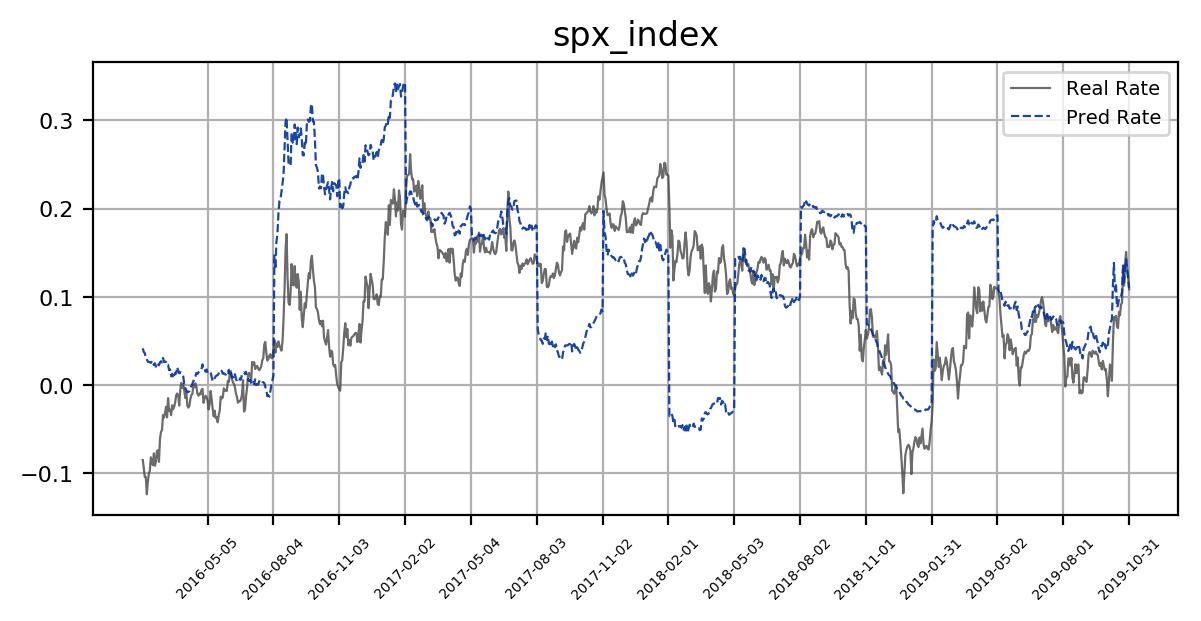

In [81]:
import matplotlib
import matplotlib.pylab as plt
% matplotlib inline
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = True
plt.title(MARKET)
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=5)
plt.plot(tmp['rate_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
plt.plot(tmp['rate_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
# plt.plot(tmp['log_diff_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
# plt.plot(tmp['log_diff_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
plt.xticks(tmp.loc[tmp['date_last_ox']].index, 
                       tmp['date_frct'][tmp.loc[tmp['date_last_ox']].index], rotation=45)
plt.legend(['Real Rate', 'Pred Rate'], prop={'size': 7}, loc=1)
plt.show()

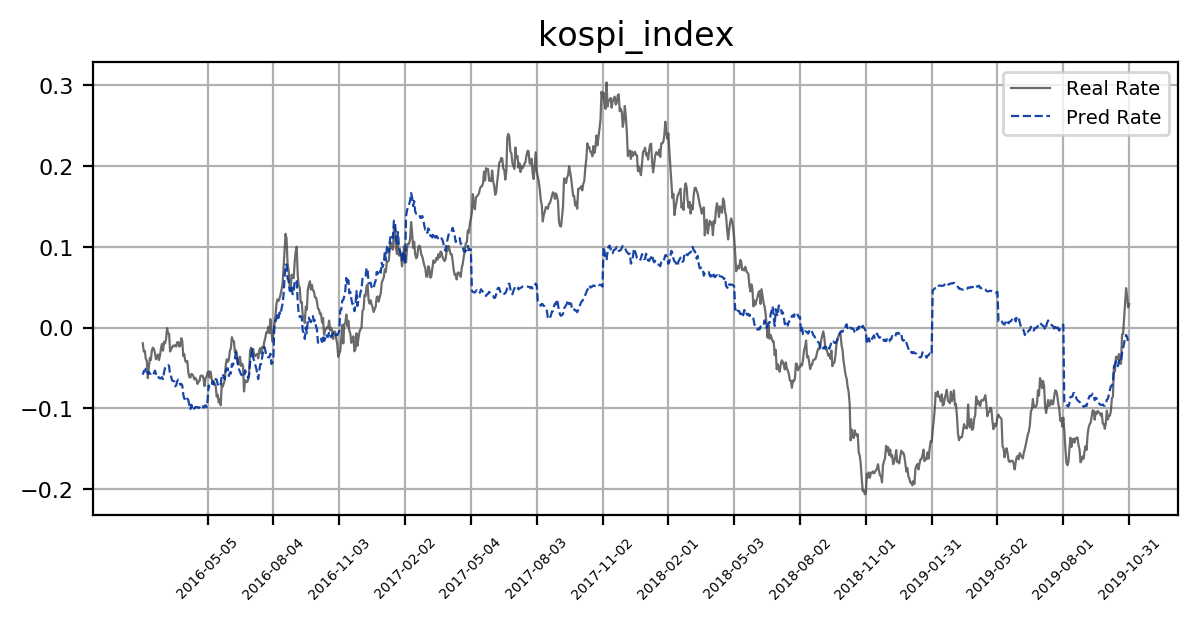

In [54]:
import matplotlib
import matplotlib.pylab as plt
% matplotlib inline
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = True
plt.title(MARKET)
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=5)
plt.plot(tmp['rate_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
plt.plot(tmp['rate_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
# plt.plot(tmp['log_diff_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
# plt.plot(tmp['log_diff_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
plt.xticks(tmp.loc[tmp['date_last_ox']].index, 
                       tmp['date_frct'][tmp.loc[tmp['date_last_ox']].index], rotation=45)
plt.legend(['Real Rate', 'Pred Rate'], prop={'size': 7}, loc=1)
plt.show()

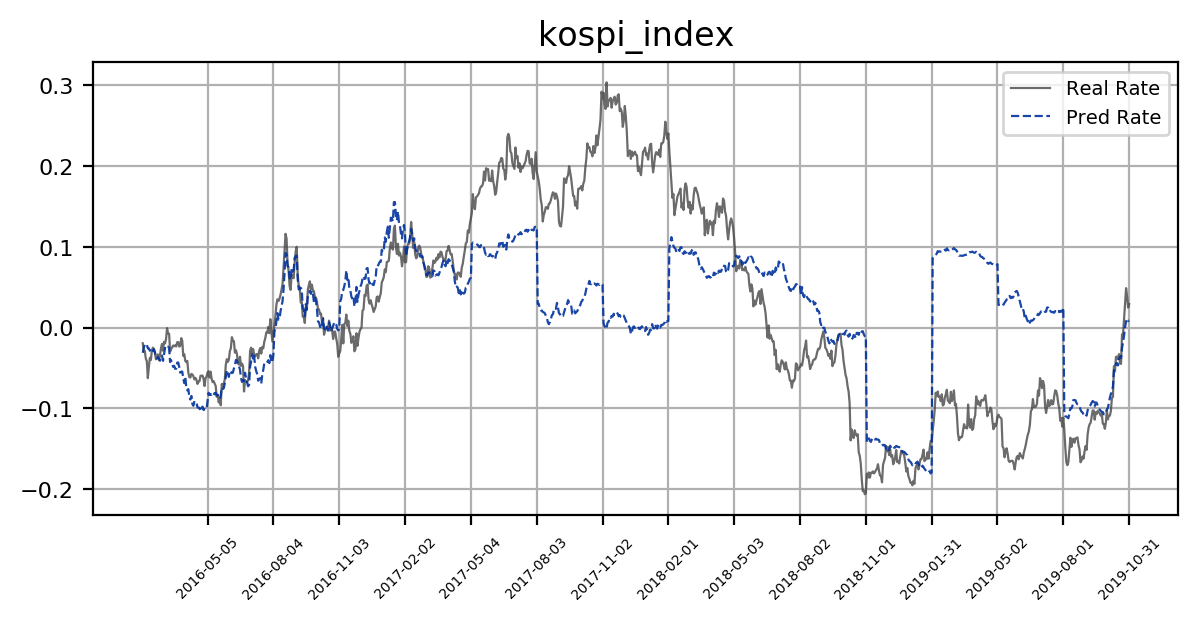

In [21]:
import matplotlib
import matplotlib.pylab as plt
% matplotlib inline
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = True
plt.title(MARKET)
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=5)
plt.plot(tmp['rate_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
plt.plot(tmp['rate_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
# plt.plot(tmp['log_diff_real'], color=(70/256, 70/255, 70/256), linewidth=0.8,alpha=0.8)
# plt.plot(tmp['log_diff_pred'],  color=(0/256,50/256,159/256), linewidth=0.8, linestyle='--', alpha=0.9)
plt.xticks(tmp.loc[tmp['date_last_ox']].index, 
                       tmp['date_frct'][tmp.loc[tmp['date_last_ox']].index], rotation=45)
plt.legend(['Real Rate', 'Pred Rate'], prop={'size': 7}, loc=1)
plt.show()

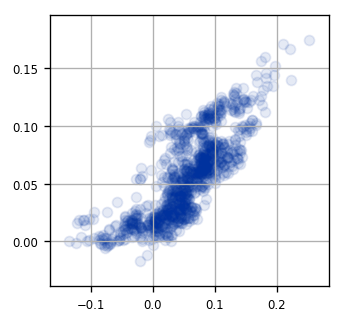

In [75]:
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["figure.dpi"] = 120
plt.rcParams['axes.grid'] = True
plt.tick_params(axis='y', labelsize=7)
plt.tick_params(axis='x', labelsize=7)
plt.scatter(tmp[['rate_real']],tmp[['rate_pred']],  color=(0/256,50/256,159/256), alpha=0.1)
# plt.scatter(tmp[['log_diff_real']],tmp[['log_diff_pred']], alpha=0.3)
plt.show()

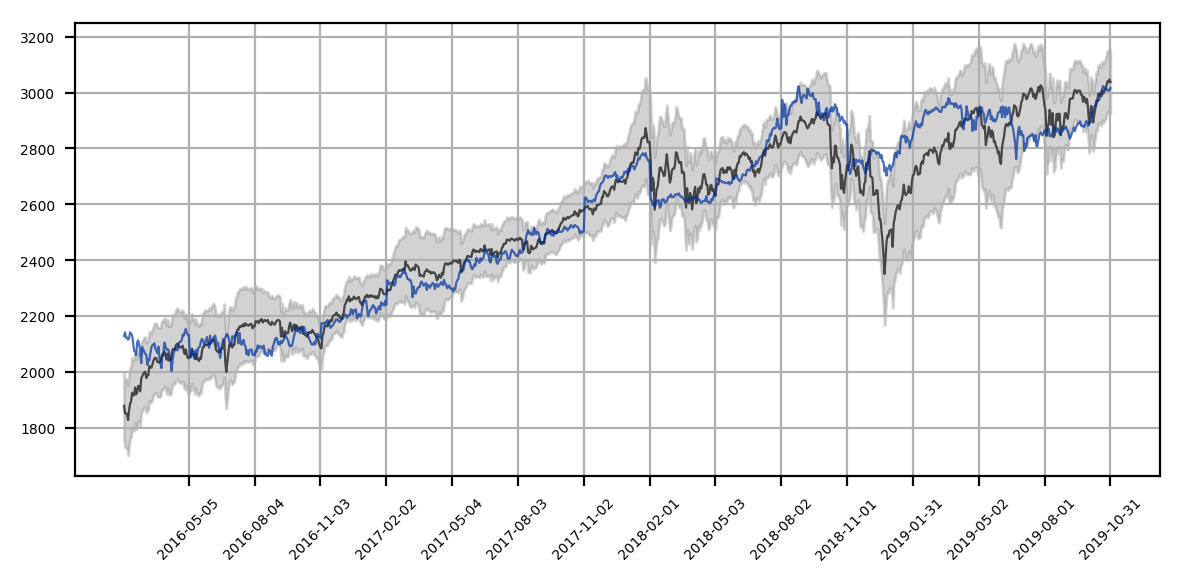

In [76]:
import matplotlib
import matplotlib.pylab as plt
% matplotlib inline
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.grid'] = True
# plt.title(MARKET)
plt.tick_params(axis='y', labelsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.plot(tmp['y_frct'], color=(70/256, 70/255, 70/256), linewidth=0.8)
plt.plot(tmp['reconverted_prediction'], color=(0/256,50/256,159/256), linewidth=0.8, linestyle='-', alpha=0.7)
# plt.plot(comparDF['prediction_cnn'], color=(222/256,50/256,159/256), linewidth=0.8, linestyle='-', alpha=0.7)
# plt.plot(comparDF['prediction_gru'], color=(0/256,50/256,159/256), linewidth=0.8, linestyle=':', alpha=0.5)
# plt.plot(comparDF['prediction_benchmark'], color=(100/256,29/256,48/256), linewidth=0.8, linestyle=':', alpha=0.5)
plt.xticks(tmp.loc[tmp['date_last_ox']].index, 
                       tmp['date_frct'][tmp.loc[tmp['date_last_ox']].index], rotation=45)
plt.fill_between(np.arange(0,tmp.shape[0],1),tmp['lower_bound_accuracy'],tmp['upper_bound_accuracy'], color='gray', alpha=0.35)
#plt.legend(['Real', 'CNN_BINARY','CNN', 'GRU', 'Benchmark'], prop={'size': 7}, loc=1, bbox_to_anchor=(1.27, 1))
plt.show()
#plt.savefig(os.path.join(performanceDir3, 'fig_perform_1.png'), dpi=200, bbox_inches='tight')